# Try HMM

https://towardsdatascience.com/hidden-markov-models-for-time-series-classification-basic-overview-a59b74e5e65b
    Normally towardsdatascience is really good but this makes no sense to me at all.

This article is more complicated, but also indepth and explains stuff more. - https://towardsdatascience.com/markov-chains-and-hmms-ceaf2c854788

Some guys github repository using HMM for binary sentimental analysis of tweets - https://github.com/FantacherJOY/Hidden-Markov-Model-for-NLP


"In the case one label is way more frequent than the other (say Class B appears for every 100 samples of Class A), or in the case one category is broader than the other (have more variance, i.e. Class A is an expected behavior of a process and Class B is all the cases that are abnormal), then we might want to train a unique HMM for Class A. For each new sample, we compute the likelihood to the model, and if it falls below a pre-defined threshold (that can be chosen with respect to some validation sample, or in the worst case, from the training samples themselves) we assign this sample to Class B. If the likelihood is above the threshold, we assign the sample to Class A." - https://datascience.stackexchange.com/questions/8560/can-hmm-be-used-as-a-binary-classifier

In [1]:
# imports
from hmmlearn import hmm
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import nltk
import pickle
import matplotlib.pyplot as plt



In [2]:
# Commented out as it doesnt need to be run which saves time
'''
# Load in data
# index_col stops index being read as column
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

# Now do some data engineering to get the targets into the format I want.
# First get the targets data in a time series of time, target, and ID.

# When we remove the mouse event we have much more duplicate data.
# Drop this data and reset the indexes to account for missing values.
# Since there was a correlation between time and number of mouse events maybe I can use index to substitue for time.

df_m_lab = df_lab[['target', 'time', 'turkId']]     # m for markov
lab_dups = len(df_m_lab)-len(df_m_lab.drop_duplicates())
print(f'Number of duplicate items in lab data: {lab_dups}')
print(f'Percentage duplicate: {lab_dups / len(df_lab) * 100}\n')
df_m_lab = df_m_lab.drop_duplicates()

df_m_turk = df_turk[['target', 'time', 'turkId']]
turk_dups = len(df_m_turk)-len(df_m_turk.drop_duplicates())
print(f'Number of duplicate items in turk data: {turk_dups}')
print(f'Percentage duplicate: {turk_dups / len(df_m_turk) * 100}')
df_m_turk = df_m_turk.drop_duplicates()

# Replace html with 0, and alloc-slider-1 to 1, alloc-slider-2 to 2, alloc-slider-3 to 3, alloc-slider-4 to 4, alloc-slider-5 to 5

df_m_lab.loc[df_m_lab['target'].str.contains('html'), 'target'] = '0'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_lab = df_m_lab['target'].to_numpy().reshape(-1, 1).astype(np.int)

df_m_turk.loc[df_m_turk['target'].str.contains('html'), 'target'] = '0'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_turk = df_m_turk['target'].astype('int32').to_numpy().reshape(-1, 1).astype(np.int)
data_turk.shape

# we want to have everything in one long array.
# But then we need to create the lengths array.

lab_lengths = []
for ID in df_m_lab['turkId'].unique():
    length_for_ID = len( df_m_lab[df_m_lab['turkId'] == ID] )
    lab_lengths.append(length_for_ID)

turk_lengths = []
for ID in df_m_turk['turkId'].unique():
    length_for_ID = len( df_m_turk[df_m_turk['turkId'] == ID] )
    turk_lengths.append(length_for_ID)

# Save arrays so data enginerring step does not need to be rerun to save time.
np.save('np_data_lab.npy', data_lab)
np.save('np_data_turk.npy', data_turk)
np.save('np_lab_lengths.npy', lab_lengths)
np.save('np_turk_lengths.npy', turk_lengths)
df_m_lab.to_csv( 'df_m_lab.csv' )
df_m_turk.to_csv( 'df_m_turk.csv' )
''';


In [3]:
# Load data
data_lab = np.load('np_data_lab.npy')
data_turk = np.load('np_data_turk.npy')
lab_lengths = np.load('np_lab_lengths.npy')
turk_lengths = np.load('np_turk_lengths.npy')
df_m_lab = pd.read_csv('df_m_lab.csv')
df_m_turk = pd.read_csv('df_m_turk.csv')

In [4]:
# Trained to:   200       -8128.0817          +0.0795
'''
lab_model = hmm.MultinomialHMM(n_components=10, random_state=0, n_iter=200, verbose=True).fit(data_lab, lab_lengths)
pickle.dump(lab_model, open('hmm_lab_model.pkl', 'wb'))
''';



In [5]:
lab_model = pickle.load(open('hmm_lab_model.pkl', 'rb'))
lab_model

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=10,
               n_iter=200, params='ste',
               random_state=RandomState(MT19937) at 0x1F5EB5356A8,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=True)

In [6]:
# Trained to:    200     -192726.6706          +2.6394
'''
turk_model = hmm.MultinomialHMM(n_components=10, random_state=0, n_iter=200, verbose=True).fit(data_turk, turk_lengths)
pickle.dump(turk_model, open('hmm_turk_model.pkl', 'wb'))
'''

"\nturk_model = hmm.MultinomialHMM(n_components=10, random_state=0, n_iter=200, verbose=True).fit(data_turk, turk_lengths)\npickle.dump(turk_model, open('hmm_turk_model.pkl', 'wb'))\n"

In [7]:
turk_model = pickle.load(open('hmm_turk_model.pkl', 'rb'))
turk_model

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=10,
               n_iter=200, params='ste',
               random_state=RandomState(MT19937) at 0x1F5F1169268,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=True)

In [8]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def model_score_list(model, data, lengths):
    # Given a model and some data and lengths return a list of likelihoods that each different data sample belongs to that HMM.

    probas = []

    start_i = 0
    #end_i = start_i + lab_lengths[0]
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        #print(i)
        #print( model.score( users_items ) )
        probas.append( model.score(users_items) )

        start_i = lengths[i] # lab_lengths[0]
        #end_i = start_i + lab_lengths[i+1]

    return probas

# Score is given as a liklihood https://web.stanford.edu/~jurafsky/slp3/A.pdf
# Somthing like summing the likelihoods of each hidden state producing the same output as the input at the same location?   
model_score_list(turk_model, data_lab, lab_lengths)    # Try lab data on turk model

[-856.0017670128934,
 -780.2180789045514,
 -777.8570657966995,
 -313.625878504536,
 -194.47185879661683,
 -1014.1042309005018,
 -414.05760232295955,
 -113.21035094281294,
 -914.1088969934353,
 -169.30755852807445,
 -1171.8483758504626,
 -1212.6530973131164,
 -716.4886955296467,
 -711.2240408984088]

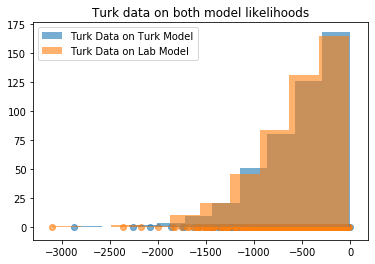

In [9]:
turk_data_turk_model = model_score_list(turk_model, data_turk, turk_lengths)  # Try turk data on turk model
turk_data_lab_model = model_score_list(lab_model, data_turk, turk_lengths)  # Try turk data on lab model

plt.hist(turk_data_turk_model, bins=10, label='Turk Data on Turk Model', alpha=0.6)
plt.hist(turk_data_lab_model, bins=10, label='Turk Data on Lab Model', alpha=0.6)

plt.title('Turk data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( turk_data_turk_model, np.zeros((len(turk_data_turk_model),1)), label='Turk Data on Turk Model', alpha=0.6 )
plt.scatter( turk_data_lab_model, np.zeros((len(turk_data_lab_model),1)), label='Turk Data on Lab Model', alpha=0.6 )

plt.show()

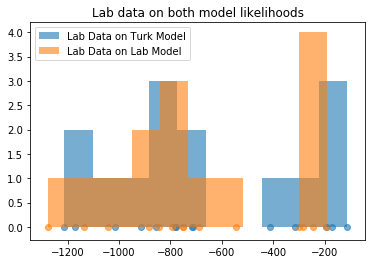

In [10]:
# This graph clearly shows that on average, the lab data is more likely to be classified as a turk model.

lab_data_turk_model = model_score_list(turk_model, data_lab, lab_lengths)  # Try lab data on turk model
lab_data_lab_model = model_score_list(lab_model, data_lab, lab_lengths)  # Try lab data on lab model

plt.hist(lab_data_turk_model, bins=10, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=10, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( lab_data_turk_model, np.zeros((len(lab_data_turk_model),1)), label='Lab Data on Turk Model', alpha=0.6 )
plt.scatter( lab_data_lab_model, np.zeros((len(lab_data_lab_model),1)), label='Lab Data on Lab Model', alpha=0.6 )

plt.show()

# Plotting results

It is hard to visulaise these results, so show them as a scatter point and a 2D histogram.
A straight line of y = x will be shown.
A point on this line will have the identily likelihoods to belong to either model.



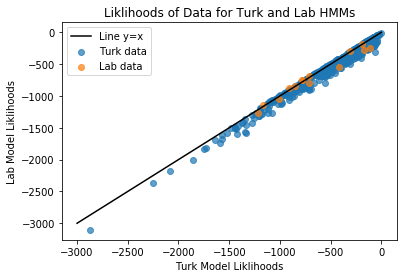

In [11]:
plt.scatter(turk_data_turk_model, turk_data_lab_model, alpha=0.7, label='Turk data')
plt.scatter(lab_data_turk_model, lab_data_lab_model, alpha=0.7, label='Lab data')

plt.title('Liklihoods of Data for Turk and Lab HMMs')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')
#plt.show()

# Linear reg of just lab data
X = np.array(lab_data_turk_model).reshape(-1,1)
y = np.array(lab_data_lab_model).reshape(-1,1)
reg = LinearRegression().fit(X, y)
#pred=reg.predict(X)
#plt.plot(X, pred, 'r', alpha=0.6)
'''
x = np.linspace(-3000,0,100)
y = reg.coef_[0][0]*x + reg.intercept_[0]
plt.plot(x, y, 'orange', label='Lab linear regression')
'''
x = np.linspace(-3000,0,100)
y = x
plt.plot(x, y, 'k', label='Line y=x')

plt.legend()

plt.show()

# Reassigning samples

Now run all lab and turk data through both models. 
Assign a predicted label (lab / online) data.
Afterwards compare actual and predicted to see if any samples seem to be missclassified.  

In [12]:

# Test readdign samples a different way.
# If a point is above and to the left of the orange line then we can say that the data matches the lab model compared to the turk model to the same extent as the actual lab data.

def reclassify_samples(turk_model, lab_model, data, lengths):
    '''
    Returns array of new classes.
    reg is a linear regression object of the lab data.
    0 is turk, 1 is lab.
    '''
    # Given a model and some data and lengths return a list of predicted new classes.

    M = reg.coef_[0][0]
    C = reg.intercept_[0]

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        Y = lab_likelihood
        X = turk_likelihood
        #print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}, \t mX+c: {M*X+C}')

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

        start_i = lengths[i] 

    return new_classes

def reclassify_samples_regression(turk_model, lab_model, data, lengths, reg):
    '''
    Returns array of new classes.
    reg is a linear regression object of the lab data.
    0 is turk, 1 is lab.
    '''
    # Given a model and some data and lengths return a list of predicted new classes.

    M = reg.coef_[0][0]
    C = reg.intercept_[0]

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        Y = lab_likelihood
        X = turk_likelihood

        # Y= MX + C is equation of straight line.
        # if Y > MX + C then the point is above the line    
        # https://math.stackexchange.com/questions/324589/detecting-whether-a-point-is-above-or-below-a-slope

        #print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}, \t mX+c: {M*X+C}')

        if ( Y > M*X + C ):
            new_classes.append(1)
        else:
            new_classes.append(0)

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

        start_i = lengths[i] 

    return new_classes

# Lab data is half classified as itself. GOOD
reclassified_lab_labels = reclassify_samples(turk_model, lab_model, data_lab, lab_lengths)
reclassified_lab_labels_reg = reclassify_samples_regression(turk_model, lab_model, data_lab, lab_lengths, reg)

print('Number of new turk labels, number of new lab labels:')
print(reclassified_lab_labels.count(0), reclassified_lab_labels.count(1))
print()
print('REG Number of new turk labels, number of new lab labels:')
print(reclassified_lab_labels_reg.count(0), reclassified_lab_labels_reg.count(1))

Number of new turk labels, number of new lab labels:
6 8

REG Number of new turk labels, number of new lab labels:
12 16


In [13]:
reclassified_turk_labels = reclassify_samples(turk_model, lab_model, data_turk, turk_lengths)    # Try turk data
reclassified_turk_labels_reg = reclassify_samples_regression(turk_model, lab_model, data_turk, turk_lengths, reg)    # Try turk data

print('Number of new turk labels, number of new lab labels:')
print(reclassified_turk_labels.count(0), reclassified_turk_labels.count(1))
print()
print('REG Number of new turk labels, number of new lab labels:')
print(reclassified_turk_labels_reg.count(0), reclassified_turk_labels_reg.count(1))

Number of new turk labels, number of new lab labels:
349 112

REG Number of new turk labels, number of new lab labels:
542 380


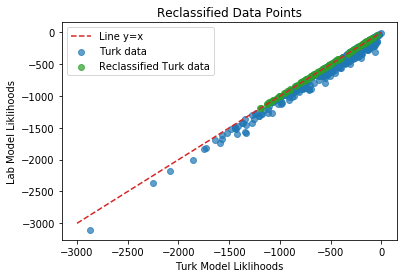

In [14]:
fig, ax = plt.subplots()

group = reclassified_turk_labels
for g in np.unique(group):
    i = np.where(group == g)
    if g == 0:
        label = 'Turk data'
        colour = 'C0'
    else:
        label = 'Reclassified Turk data'
        colour = 'C2'
    ax.scatter(np.array(turk_data_turk_model)[i], np.array(turk_data_lab_model)[i], c=colour, label=label, alpha=0.7)

#ax.scatter(lab_data_turk_model, lab_data_lab_model, c='C1', alpha=0.7, label='Lab data')

plt.title('Reclassified Data Points')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')

x = np.linspace(-3000,0,100)
y = x
plt.plot(x, y, 'C3', label='Line y=x', linestyle='dashed', alpha=1)

plt.legend()

plt.show()

# These scatterplots show that there is not anywhere near as much variance with the turk model predictions as the lab model predictions.
# Probably due to the fact we didtnt have much data to train the lab model with.
# The positive quadrant shows that shows that while the turk likelihoods are always slightly higher, theyre directly correlated and not much difference.
# Can we accume any positive likelihood from the lab model using turk data means theyre paying attention?

   Turk likelihoods  Lab likelihoods  Difference   ID
0       -856.001767      -842.451990  -13.549777  ID1
1       -780.218079      -751.082228  -29.135851  ID2
2       -777.857066      -749.746503  -28.110563  ID3
3       -313.625879      -298.308668  -15.317211  ID4
4       -194.471859      -190.477934   -3.993925  ID5


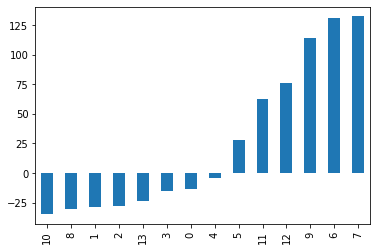

In [15]:
def compare_model_liklihoods(turk_model, lab_model, data, lengths, IDs):
    # Given a model and some data and lengths return a dataframe of each user, and the liklihoods for different models.
    # Difference is turklikelihood - lab_liklihood.
    # Therefore a high positive number means its firmly turk, a low negative number means its firmly lab.

    res = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)
        difference = turk_likelihood - lab_likelihood
        ID = IDs[i]

        res.append( (turk_likelihood, lab_likelihood, difference, ID) )

        start_i = lengths[i] 

    df = pd.DataFrame.from_records(res, columns =['Turk likelihoods', 'Lab likelihoods', 'Difference', 'ID']) 

    return df

df_lab_diff = compare_model_liklihoods(turk_model, lab_model, data_lab, lab_lengths, df_m_lab['turkId'].unique().tolist())    # Try lab data
print(df_lab_diff.head())
df_lab_diff['Difference'].sort_values().plot(kind='bar')

   Turk likelihoods  Lab likelihoods  Difference              ID
0       -137.839044      -132.472534   -5.366509  A35YFAFWP33C70
1       -124.618859      -130.289870    5.671011  A33XI8ZN4NZ0SQ
2       -219.483264      -370.936870  151.453606  A1ZG7VYH0DUEXW
3       -134.928433      -136.788861    1.860428  A1RXG8RE0SJ4LC
4        -38.952128       -49.117919   10.165791   AUDH0P4ZHJKS2


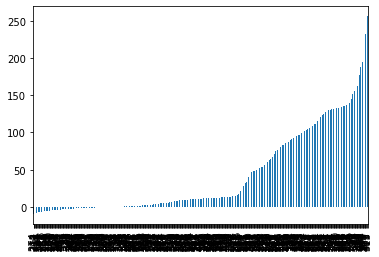

In [16]:
df_turk_diff = compare_model_liklihoods(turk_model, lab_model, data_turk, turk_lengths, df_m_turk['turkId'].unique())    # Try turk data
print(df_turk_diff.head())
df_turk_diff['Difference'].sort_values().plot(kind='bar')

# Link between length of mouse events and likelihood?

From an breif exploration of the likelihoods and through tableau it looks like the users with longer sequences have mainly high likelihoods for turk data, and shorter sequences have higher likelihood for lab data.

Plot likelihood difference and length of mouse evetns to see if there is actually a strong correlation.



In [32]:
len(X.flatten()), len(y)

(475, 8000)

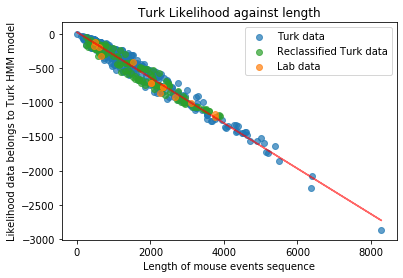

Pearsons correlation: -0.982


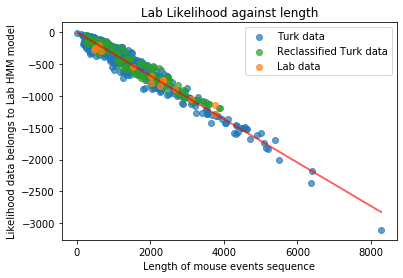

Pearsons correlation: -0.976


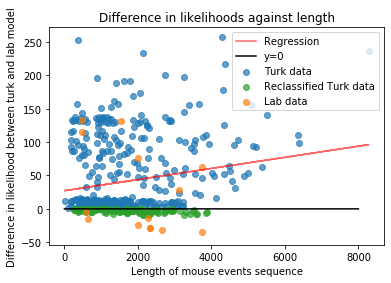

Pearsons correlation: 0.176


In [35]:
# Turk plot
fig, ax = plt.subplots()
group = reclassified_turk_labels
for g in np.unique(group):
    i = np.where(group == g)
    if g == 0:
        label = 'Turk data'
        colour = 'C0'
    else:
        label = 'Reclassified Turk data'
        colour = 'C2'
    ax.scatter(np.array(turk_lengths)[i], np.array(df_turk_diff['Turk likelihoods'])[i], c=colour, label=label, alpha=0.7)

plt.scatter(lab_lengths, df_lab_diff['Turk likelihoods'], c='C1', alpha=0.7, label='Lab data')
plt.title('Turk Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Turk HMM model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Turk likelihoods'].append(df_lab_diff['Turk likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.legend()
plt.show()

corr, _ = pearsonr(X.flatten(), y.flatten())
print('Pearsons correlation: %.3f' % corr)

# Lab plot
fig, ax = plt.subplots()
group = reclassified_turk_labels
for g in np.unique(group):
    i = np.where(group == g)
    if g == 0:
        label = 'Turk data'
        colour = 'C0'
    else:
        label = 'Reclassified Turk data'
        colour = 'C2'
    ax.scatter(np.array(turk_lengths)[i], np.array(df_turk_diff['Lab likelihoods'])[i], c=colour, label=label, alpha=0.7)

plt.scatter(lab_lengths, df_lab_diff['Lab likelihoods'], c='C1', alpha=0.7, label='Lab data')

plt.title('Lab Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Lab HMM model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Lab likelihoods'].append(df_lab_diff['Lab likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.legend()
plt.show()

corr, _ = pearsonr(X.flatten(), y.flatten())
print('Pearsons correlation: %.3f' % corr)

# Difference plot
fig, ax = plt.subplots()
group = reclassified_turk_labels
for g in np.unique(group):
    i = np.where(group == g)
    if g == 0:
        label = 'Turk data'
        colour = 'C0'
    else:
        label = 'Reclassified Turk data'
        colour = 'C2'
    ax.scatter(np.array(turk_lengths)[i], np.array(df_turk_diff['Difference'])[i], c=colour, label=label, alpha=0.7)

plt.scatter(lab_lengths, df_lab_diff['Difference'], c='C1', alpha=0.7, label='Lab data')
plt.title('Difference in likelihoods against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Difference in likelihood between turk and lab model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Difference'].append(df_lab_diff['Difference'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6, label='Regression')

x = np.linspace(0,8000,8000)
Y = 0*x
plt.plot(x, Y, 'k', label='y=0')
plt.legend()
plt.show()

corr, _ = pearsonr(X.flatten(), y.flatten())    
print('Pearsons correlation: %.3f' % corr)

In [36]:

reclassified_IDs = df_turk_diff[df_turk_diff['Difference'] < 0]['ID'].to_numpy()
print(len(df_turk_diff[df_turk_diff['Difference'] < 0]))
reclassified_IDs
# IDs with higher liklihood for the lab class, compared to turk class.

112


array(['A35YFAFWP33C70', 'A29D1BMFCC7XA1', 'AE3XJ3B4K4B15',
       'A1FA2AJUFESR5T', 'A37MEXKALGBQWN', 'A1O2S71TYP1AFC',
       'A2CIGX8GOEE58M', 'AVI7K876BV3QL', 'A2GSSXKTPAEL6D',
       'A24DZU2LIWZQCG', 'A2Y1AMYG74XRDO', 'A1067MT5UGN8Z8',
       'A3F82HVRIPI02N', 'A2GPMBGECD9TQY', 'AYW18ODUQFXF',
       'A2Z11BHUBDVKMB', 'A36470UBRH28GO', 'A23SGBJULXN5DO',
       'A19XS2I3H4JOJ8', 'A12J9J42MYQDRY', 'A30OOETQPWFPHK',
       'A3MELYYGRJ61SX', 'A28I7Y2NPDZTIN', 'A2TDLLB8JTZGBN',
       'A11O7VHY5Y5QUX', 'AJPQEZBVJXVE9', 'A1DGAZZZHY4FXG',
       'A3SFNMTK31EBV1', 'AC2TZJY3V7YVU', 'A1SS75GZE2AUOQ',
       'AQAXDL1INQC9Q', 'AAX1G2KA4ZD2N', 'ANPTFK4AAFGA1',
       'A2XM6C78S9L8UG', 'A1DZMDFI9U604W', 'A1HNTXZAIPFQNF',
       'A14U4WPDS8ITPQ', 'ATIWKEQ7WB1VH', 'A3PNHCZVCBIEJ1',
       'A2JQTK2ARSX01R', 'A3OF9HAEZVBQ3G', 'A2URTGY72HXIGG',
       'A3AM7D2UWBRS7Z', 'A21Y22J7Q0KSGN', 'A312SMN11YLE66',
       'A3QY3I5O0STFGA', 'AF3TLR0FI08K0', 'AWSCR2O3D6T87',
       'AFWKRID53R1XA', 'A2M2BNQ1XW3

In [37]:
df_turk_diff.sort_values(['Difference'])['ID'].head(100).to_numpy()

array(['A39QYYAATL2XFT', 'A1NFBKUYYVUYWF', 'A7XL1V3G7C2VV',
       'A12176C3392N51', 'ACOKFBC75D5OR', 'A2GPMBGECD9TQY',
       'A1HNTXZAIPFQNF', 'A3QY3I5O0STFGA', 'AKI26MOILD9LU',
       'A2CKW83ERUX07J', 'ABFB6SB7ZPA3D', 'A29D1BMFCC7XA1',
       'A2VTRIPL7H0IZH', 'A3AM7D2UWBRS7Z', 'A3H7LONGSJ9384',
       'A12J9J42MYQDRY', 'AF3TLR0FI08K0', 'A8KX1HFH8NE2Q',
       'A2OYWTFK9MCYJ1', 'A2S4YDJ9UGAXFQ', 'A1067MT5UGN8Z8',
       'A14U4WPDS8ITPQ', 'A35YFAFWP33C70', 'A2YL64PU2DBHTB',
       'A2BA9Y6VGW6WS1', 'AOAZMLP27GD81', 'ANVAFB99K5RKP',
       'A2Z11BHUBDVKMB', 'A28I7Y2NPDZTIN', 'A1DZMDFI9U604W',
       'ACSZ7IOG3J5NR', 'A2JCK494NV7TFX', 'ABUNAEPK8GV63',
       'A1SS75GZE2AUOQ', 'A1ETJBNTO9ZWZ8', 'A31XNLA9REVGXL',
       'A2749DC85C9H0F', 'A28G4QO0DRY8OZ', 'A1YJKLVJW1FE33',
       'A4PFM9Z80RXUY', 'AVI7K876BV3QL', 'AGVUHOBSCP6YC',
       'A2CIGX8GOEE58M', 'A2GSSXKTPAEL6D', 'A19XS2I3H4JOJ8',
       'A2NJ7N8INZOB00', 'A2KFOOEQWGN0GK', 'A3F82HVRIPI02N',
       'A1ONILGBGJ8Y5K', 'A1DGAZZZHY4

# AMAZING IDEA

hmmlearn has the function .SAMPLE(n). This Generates random samples from the model.

With some effort could potentially use this to generate new samples for lab data!

In [38]:
from scipy.stats import norm

In [39]:
# See if lab_lengths follow a normal distribution
# Lab lengths kind of follow this distribution but not really.
#https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data
'''
from scipy.stats import norm
from scipy.stats import lognorm

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

mu, std = norm.fit(turk_lengths)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

#dist=lognorm([std],loc=mean)
lognorm_dist = lognorm(s=std, loc=mu)
p2 = lognorm(*lnorm)

plt.plot(x, lognorm_dist.pdf(x), 'y', linewidth=2)

title = "Turk Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()



from scipy.stats import norm

data = turk_lengths
ogdata = np.log(data)
estimated_mu, estimated_sigma = norm.fit(logdata)

x = np.linspace(xmin, xmax, 100)
pdf = norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')


# plot histogram in log space
logdata = np.log(data)
plt.hist(logdata, bins=25)


shape,loc,scale = lognorm.fit(data)

x = np.logspace(0, 5, 200)
pdf = lognorm.pdf(x, shape, loc, scale)

plt.plot(x, pdf, 'r')

''';

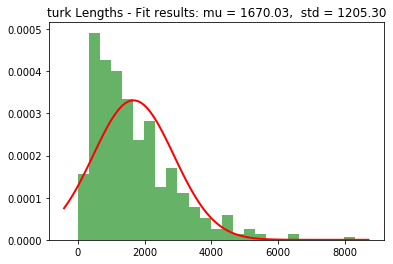

In [40]:
# See if turk data follows a distrinution

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "turk Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

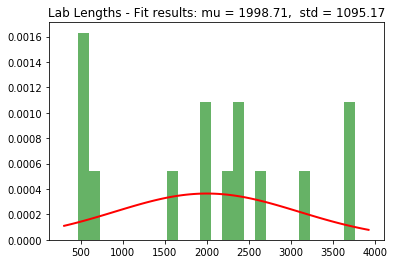

In [41]:
# See if Lab data follows a distrinution

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Lab Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

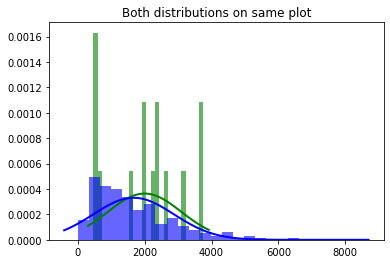

In [42]:
# Both on 1 graph?

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'g', linewidth=2)
plt.title('Both distributions on same plot')

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'b', linewidth=2)

plt.show()

Text(0.5, 1.0, 'Both Lengths - Fit results: mu = 1679.72,  std = 1203.48')

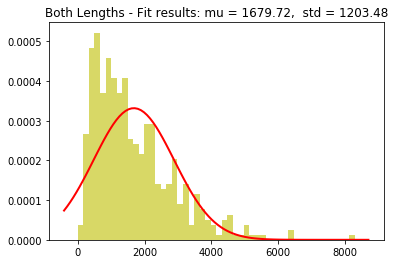

In [43]:
# Combine both data together and see what the distribution looks like
# Probably a bit pointless as the turk data will still be so much more numerous

both_lengths = np.append(turk_lengths,lab_lengths)
both_lengths = np.array(np.append(turk_lengths,lab_lengths), dtype=float)

mu, std = norm.fit(both_lengths)

plt.hist(both_lengths, bins=50, density=True, alpha=0.6, color='y')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Both Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

# Length Distributions.
Thought this would be a failure at first but this is actually really amazing!
Can CLEARLY see a distribution off turk lengths, and we could explain you not seeing a distribtion in lab data because there is so little many samples.

For Turk and Lab the means are:

|  | Mean | S.D |
| --- | --- | --- |
| Turk | 1677 | 1235 |
| Lab | 1998 | 1095 |

Which are not identical, but as I've showed with the ealier PCA attempts lengths cannot be used to differenciate data points.
Theyre similar enough that I can assume they follow the SAME distribtion.


# Synthesize data
We can generate sequences of any length specified.
todo sample length from a normal distribution matching the lab or turk data depending on what class im creating more samples for.

In [44]:
# Shows we need to create 367 (381-14) lab samples to have classes of the same length.
# OR: synthesize 381 lab datas, then use the actual lab data as my TESTING set.
len(turk_lengths), len(lab_lengths), len(np.append(lab_lengths, turk_lengths))

(461, 14, 475)

In [45]:
# Sample points from distributions of lengths, using their mean, and sd.

num_generated_samples = len(turk_lengths)   # Create enough sampels so classes are equally sized

# Create gaussian parameters from all data, as there wasnt much difference
mu, std = norm.fit(np.append(lab_lengths, turk_lengths))

generated_lengths = np.random.normal(loc=mu, scale=std, size=num_generated_samples)   
# Creating 300 more samples would make the classes even ish.

# Remove any 0 values from generated lengths
while 0 in generated_lengths:
    generated_lengths = np.random.normal(loc=mu, scale=std, size=num_generated_samples)


# https://stackoverflow.com/a/38406535/11902832
# Remove negative values, but now its not really a normal distribution
# TODO: Try a log normal, but wasnt working for me
generated_lengths = abs(generated_lengths).astype(int)



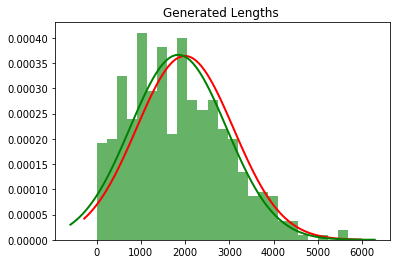

In [46]:
# Shows created data follows pretty much the same distribution as the original data.

plt.hist(generated_lengths, bins=25, density=True, alpha=0.6, color='g')

# Original lab distribution
mu, std = norm.fit(lab_lengths)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

# New generated distribution
mu, std = norm.fit(generated_lengths)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'g', linewidth=2)

title = "Generated Lengths "
plt.title(title)

plt.show()

In [47]:
# Generate the data. Note this will take a long time.

created_data = []
for i in generated_lengths:

    X, Z = lab_model.sample(i)  # This generates a new sample, length of which is taken from the normal distribution

    created_data.append( np.concatenate(X).ravel().astype(int).astype(str).tolist() ) # list of nps flattened, and to ints

len(created_data)

461

In [48]:
# we have array of length 381, each of which contains events of varing lengths.

IDs = []    # This will be the length of the flattened array. will be like ID1, ID1, ID2 etc
targets = []

for i in range(len(created_data)):    
    targets.extend(created_data[i])

    for j in range(len(created_data[i])):
        IDs.append(f'ID{i}')


In [49]:
df = pd.DataFrame({'target':targets, 'turkId':IDs}) 
df.astype(object)
#df['target'] = df['target'].rename({'0' :'html', '1':'Slider-1', '2':'Sliders-2', '3':'Slider-3', '4':'Slider-4', '5':'Slider-5'})

df['target'] = df['target'].replace('0','html')
df['target'] = df['target'].replace('1','alloc-slider-1')
df['target'] = df['target'].replace('2','alloc-slider-2')
df['target'] = df['target'].replace('3','alloc-slider-3')
df['target'] = df['target'].replace('4','alloc-slider-4')
df['target'] = df['target'].replace('5','alloc-slider-5')

df

,target,turkId
0,html,ID0
1,html,ID0
2,html,ID0
3,html,ID0
4,html,ID0
...,...,...
851142,alloc-slider-3,ID460
851143,alloc-slider-3,ID460
851144,alloc-slider-3,ID460
851145,alloc-slider-3,ID460


In [50]:
df.to_csv('created_labs.csv')

Tableau images https://imgur.com/a/FagaiQW
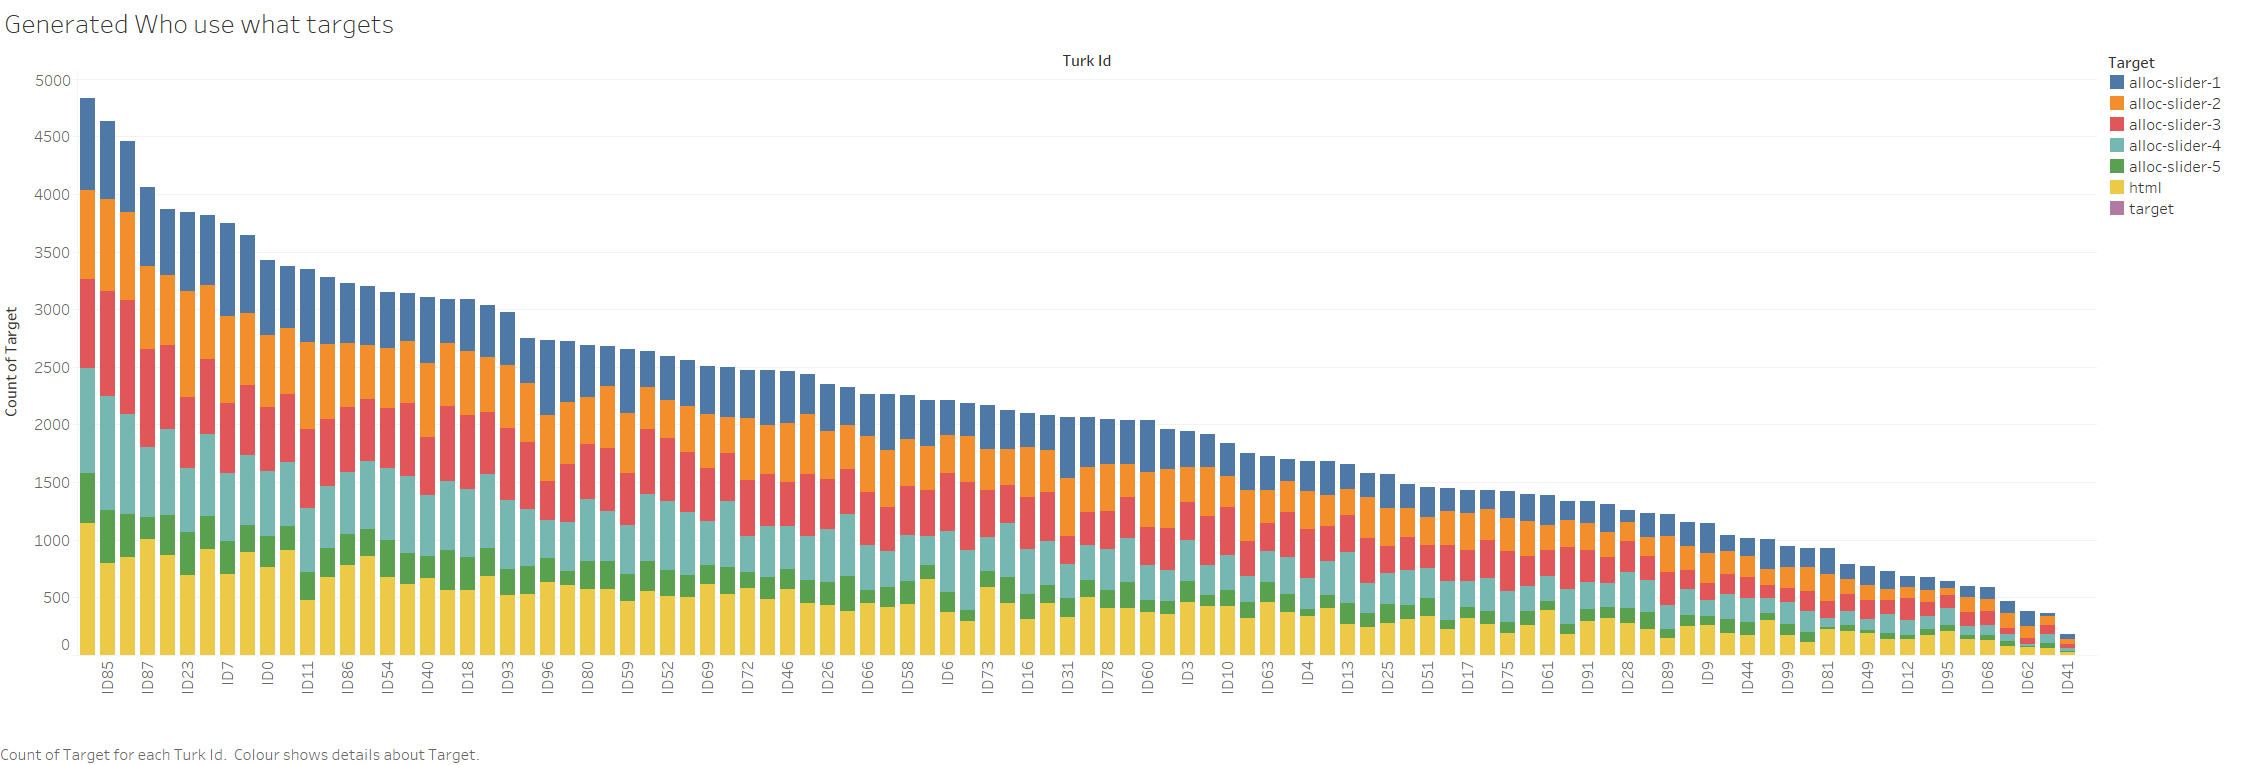

TODO: Remove generated lab data where not all sliders have been selected.
Some of the generated data doesnt have any records of slider-1 being selected for example

Now weve generated some more data samples see if the generated data sampels would be identified by the lab hmm not the turk hmm.



In [51]:
flatten_created_data = np.concatenate(created_data).ravel().astype(int).reshape(-1,1)


reclassified_labels = reclassify_samples(turk_model, lab_model, flatten_created_data, generated_lengths)    # Try generated lab data

print('Number of new turk labels, number of new lab labels:')
reclassified_labels.count(0), reclassified_labels.count(1)

Number of new turk labels, number of new lab labels:


(185, 276)

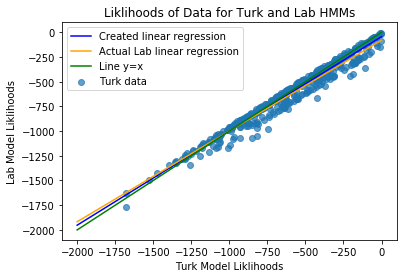

In [52]:
#############################################################################################################################

created_data_turk_model = model_score_list(turk_model, flatten_created_data, generated_lengths)
created_data_lab_model = model_score_list(lab_model, flatten_created_data, generated_lengths)

plt.scatter(created_data_turk_model, created_data_lab_model, alpha=0.7, label='Turk data')

plt.title('Liklihoods of Data for Turk and Lab HMMs')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')
#plt.show()

# Linear reg of just lab data
X = np.array(created_data_turk_model).reshape(-1,1)
y = np.array(created_data_lab_model).reshape(-1,1)
created_reg = LinearRegression().fit(X, y)
#pred=reg.predict(X)
#plt.plot(X, pred, 'r', alpha=0.6)

x = np.linspace(-2000,0,100)
y = created_reg.coef_[0][0]*x + created_reg.intercept_[0]
plt.plot(x, y, 'blue', label='Created linear regression')

# Actual Lab
X = np.array(lab_data_turk_model).reshape(-1,1)
y = np.array(lab_data_lab_model).reshape(-1,1)
reg = LinearRegression().fit(X, y)

x = np.linspace(-2000,0,100)
y = reg.coef_[0][0]*x + reg.intercept_[0]
plt.plot(x, y, 'orange', label='Actual Lab linear regression')

x = np.linspace(-2000,0,100)
y = x
plt.plot(x, y, 'green', label='Line y=x')

plt.legend()

plt.show()

In [53]:
#idea: maybe the liklihoods are messed up because of the inbalanece in training size when orriginally training?
# Try duplicating training samples NOW, or retrain on the created data.

# Increaed number of iterations from 10 to 30
generated_model = hmm.MultinomialHMM(n_components=6, n_iter=50, verbose=True).fit(flatten_created_data, generated_lengths.tolist()) # not sure why not working.
generated_model

         1    -1558993.6443             +nan
         2    -1475108.2976      +83885.3467
         3    -1367237.4116     +107870.8860
         4    -1076640.6528     +290596.7588
         5     -831582.8150     +245057.8378
         6     -723038.8939     +108543.9211
         7     -626005.1196      +97033.7744
         8     -603648.4864      +22356.6332
         9     -600565.1820       +3083.3044
        10     -598753.8164       +1811.3656
        11     -594550.4152       +4203.4012
        12     -563493.8210      +31056.5942
        13     -458539.9023     +104953.9187
        14     -427926.3802      +30613.5221
        15     -415065.8703      +12860.5100
        16     -330104.9036      +84960.9667
        17     -257805.6222      +72299.2814
        18     -254045.2509       +3760.3713
        19     -253940.0754        +105.1755
        20     -253924.3004         +15.7750
        21     -253917.4814          +6.8190
        22     -253912.2637          +5.2177
        23

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=6,
               n_iter=50, params='ste',
               random_state=RandomState(MT19937) at 0x1F5EB97FAE8,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=True)

In [54]:
reclassify_samples(turk_model, generated_model, data_turk, turk_lengths) 

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,


   Turk likelihoods  Lab likelihoods  Difference              ID
0       -137.839044      -132.281370   -5.557674  A35YFAFWP33C70
1       -124.618859      -131.358470    6.739611  A33XI8ZN4NZ0SQ
2       -219.483264      -226.584267    7.101003  A1ZG7VYH0DUEXW
3       -134.928433      -137.403770    2.475337  A1RXG8RE0SJ4LC
4        -38.952128       -39.105966    0.153838   AUDH0P4ZHJKS2


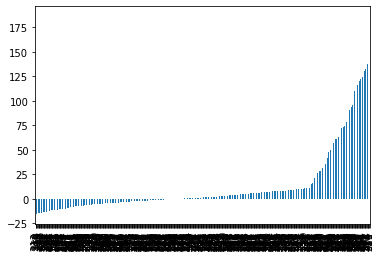

In [55]:
df_turk_diff = compare_model_liklihoods(turk_model, generated_model, data_turk, turk_lengths, df_m_turk['turkId'].unique())    # Try turk data
print(df_turk_diff.head())
df_turk_diff['Difference'].sort_values().plot(kind='bar')

# NLP methods again 

See if the naive bayes of n-grams distribution will work better.

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [57]:
def make_cm(cm):
    # Makes a confustion matrix
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.suptitle('0=online, 1=lab')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [58]:
created_data[0][:10]

['0', '0', '0', '0', '0', '1', '2', '2', '2', '2']

In [59]:
# Converts a pandas datafram of targets to a list of strings
def targets_to_string(dataframe):
    IDs = dataframe['turkId'].unique()
    targets_text = []

    for ID in IDs:
        targets_series = dataframe[ dataframe['turkId'] == ID ] ['target']
        targets =  ','.join(targets_series)
        targets_text.append( targets)
        #targets_text = targets

    return targets_text

df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

turk_targets = targets_to_string(df_turk)
lab_targets = targets_to_string(df_lab)
generated_targets = targets_to_string(df)

turk_labels = np.zeros( len(turk_targets) )
lab_labels = np.ones( len(lab_targets) )
generated_labels = np.ones( len(generated_targets) )


In [60]:
# TODO: I think I only get the first 114 because i only generate 100 new samples??
# TODO: Generate 381 new sampels and see how that effects accuracy of algorithms

print(len(turk_labels), len(lab_labels), len(generated_labels))

# Removed actual lab labels from training data.
X = np.concatenate((turk_targets, generated_targets)).ravel()
X_test = lab_targets
y = np.concatenate((turk_labels, generated_labels)).ravel()
y_test = lab_labels.ravel()

len(X), len(y)

461 14 461


(922, 922)

In [61]:
# OLD
# Test train split 
#X_train, X_test, y_train, y_test = train_test_split(X, y)

Accuracy: 0.66 (+/- 0.09)
f1 score: 0.64 (+/- 0.10)
accuracies:  [0.67567568 0.72972973 0.67934783 0.59782609 0.625     ]
f1 scores:   [0.6589233  0.72384762 0.65487204 0.57990868 0.59379299]
[[202 259]
 [ 55 406]]


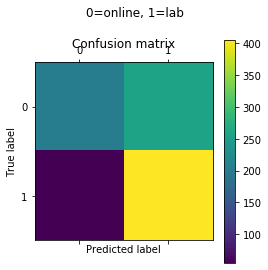

Test/Actual Lab Data:
Accuracy: 0.8571428571428571
F1 score: 0.4615384615384615
[[ 0  0]
 [ 2 12]]


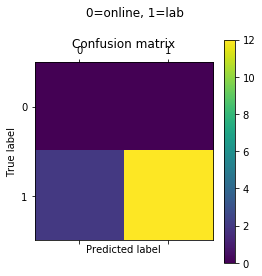

In [62]:
# Try NB model with k-cross validation

vectoriser = CountVectorizer(token_pattern='(.*?,)').fit(X)

X_vectorised = vectoriser.transform(X)
classifier = MultinomialNB()

scoresacc = cross_val_score(classifier, X_vectorised, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scoresacc.mean(), scoresacc.std() * 2))
scoresf1 = cross_val_score(classifier, X_vectorised, y, cv=5, scoring='f1_macro')
print("f1 score: %0.2f (+/- %0.2f)" % (scoresf1.mean(), scoresf1.std() * 2))

print( 'accuracies: ', scoresacc )
print( 'f1 scores:  ', scoresf1 ) 

# Youre not supposed to use these predictions like this, but the cm still shows interesting information? i think
# https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn

y_pred = cross_val_predict(classifier, X_vectorised, y, cv=10)
cm = confusion_matrix(y, y_pred)
print(cm)
make_cm(cm)

# Try NB model on actual lab / testing data
X_test_vectorised = vectoriser.transform(X_test)
classifier = MultinomialNB().fit(X_vectorised, y)
y_pred = classifier.predict(X_test_vectorised)

print('Test/Actual Lab Data:')
print( f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print( f'F1 score: {f1_score(y_test, y_pred, average="macro")}' )
cm = confusion_matrix(y_test, y_pred)
print(cm)
make_cm(cm)

In [63]:
 # This seems to say that nb finds it easiest to identify lab data as lab data.
 # This makes sence as lab data is created forom an actual model and distribution rather than being created randomly.
# THen we have to consider the actual question of the dis, can we identify whos paying attention?
# Maybe say the 12ish turks falsly predicted to be labs were paying attention??
# Seems like a big leap to say that.

 # TODO do with full dataset of 300 for turks, so generate more lab data.

# Naive Bayes with N-grams

above did naive bayes on counts of items, see if looking at ngrams effects accuracy.

Accuracy: 0.66 (+/- 0.09)
f1 score: 0.64 (+/- 0.10)
accuracies:  [0.67567568 0.72972973 0.67391304 0.60326087 0.63043478]
f1 scores:   [0.6589233  0.72384762 0.64791427 0.58459873 0.59835645]
[[202 259]
 [ 52 409]]


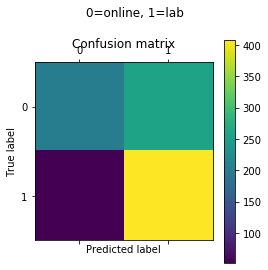

Test/Actual Lab Data:
Accuracy: 0.8571428571428571
F1 score: 0.4615384615384615
[[ 0  0]
 [ 2 12]]


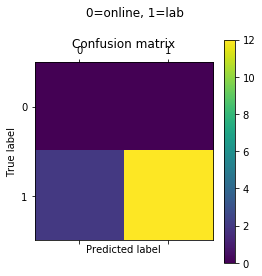

In [64]:
# Try NB model bigrams with k-cross validation

vectoriser = CountVectorizer(token_pattern='(.*?,)', ngram_range=(2, 2)).fit(X)

X_vectorised = vectoriser.transform(X)
classifier = MultinomialNB()

scoresacc = cross_val_score(classifier, X_vectorised, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scoresacc.mean(), scoresacc.std() * 2))
scoresf1 = cross_val_score(classifier, X_vectorised, y, cv=5, scoring='f1_macro')
print("f1 score: %0.2f (+/- %0.2f)" % (scoresf1.mean(), scoresf1.std() * 2))

print( 'accuracies: ', scoresacc )
print( 'f1 scores:  ', scoresf1 ) 

# Youre not supposed to use these predictions like this, but the cm still shows interesting information? i think
# https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn

y_pred = cross_val_predict(classifier, X_vectorised, y, cv=10)
cm = confusion_matrix(y, y_pred)
print(cm)
make_cm(cm)

# Try NB ngrams model on actual lab / testing data

X_test_vectorised = vectoriser.transform(X_test)
classifier = MultinomialNB().fit(X_vectorised, y)
y_pred = classifier.predict(X_test_vectorised)

print('Test/Actual Lab Data:')
print( f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print( f'F1 score: {f1_score(y_test, y_pred, average="macro")}' )
cm = confusion_matrix(y_test, y_pred)
print(cm)
make_cm(cm)

In [65]:
# AMAZING!!!!!
# Very clearly can seperate the classes looking at the bigrams!!!!!

# Still questions of how to extend that to attention or not lol.
# Potentially add section on how to generate more lab data since we cant do lab studdies because of corona.

Accuracy: 0.67 (+/- 0.10)
f1 score: 0.65 (+/- 0.11)
accuracies:  [0.69189189 0.74054054 0.67391304 0.59782609 0.64130435]
f1 scores:   [0.67341819 0.73400431 0.64791427 0.57990868 0.61016949]
[[202 259]
 [ 46 415]]


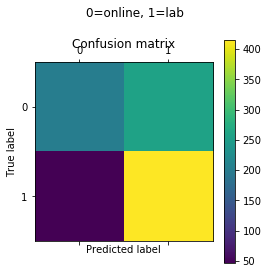

Test/Actual Lab Data:
Accuracy: 0.8571428571428571
F1 score: 0.4615384615384615
[[ 0  0]
 [ 2 12]]


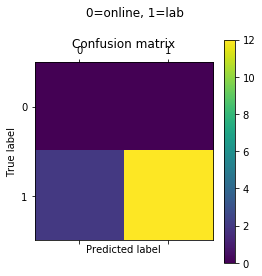

In [66]:
# Try NB model bigrams with k-cross validation

vectoriser = CountVectorizer(token_pattern='(.*?,)', ngram_range=(3, 3)).fit(X)

X_vectorised = vectoriser.transform(X)
classifier = MultinomialNB()

scoresacc = cross_val_score(classifier, X_vectorised, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scoresacc.mean(), scoresacc.std() * 2))
scoresf1 = cross_val_score(classifier, X_vectorised, y, cv=5, scoring='f1_macro')
print("f1 score: %0.2f (+/- %0.2f)" % (scoresf1.mean(), scoresf1.std() * 2))

print( 'accuracies: ', scoresacc )
print( 'f1 scores:  ', scoresf1 ) 

# Youre not supposed to use these predictions like this, but the cm still shows interesting information? i think
# https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn

y_pred = cross_val_predict(classifier, X_vectorised, y, cv=10)
cm = confusion_matrix(y, y_pred)
print(cm)
make_cm(cm)

# Try NB ngrams model on actual lab / testing data

X_test_vectorised = vectoriser.transform(X_test)
classifier = MultinomialNB().fit(X_vectorised, y)
y_pred = classifier.predict(X_test_vectorised)

print('Test/Actual Lab Data:')
print( f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print( f'F1 score: {f1_score(y_test, y_pred, average="macro")}' )
cm = confusion_matrix(y_test, y_pred)
print(cm)
make_cm(cm)

In [67]:
# Retry the log normal distribution for histograms.

In [68]:
# TODO TODO TODO: SEE HOW MUCH LOWER LIKLIHOOD THE LAB DATAPOINTS GET ON THE TURK HMM. IF THEYRE ALL STRONG OUTLIERS (10%-20%) THEN WE CAN SAY THESE POINTS CLEARLY DONT BELONG TO THIS CLASS AND THIS IS BECAUSE AS LAB STUDY PARTICIPANTS THEYRE PAYING ATTENTION WHICH HAS CAUSED THEM TO ACT DIFFERENTLY.  

In [69]:
# Curious TODO: See if the states of the HMM relate to the sequence. for example does slider-1 actually repalte to state 1, or does it relate to state 1 and state 2 or even jsut state 6

In [70]:
len(flatten_created_data)

851147

In [71]:
created_data_turk_model = model_score_list(turk_model, flatten_created_data, generated_lengths)
